In [ ]:
import numpy as np
import pandas as pd

np.set_printoptions(precision=3, suppress=True)


In [ ]:
annotators = ['x', 'y']
train_sheet = pd.read_csv('/content/train.csv', sep=',', usecols=range(22))
test_sheet = pd.read_csv('/content/test.csv', sep=',', usecols=range(22))


#creating list with all column names from our sample sheet
column_names_raw = list(train_sheet.columns.values);

#manually removed two first columns
column_names_raw.remove('Unnamed: 0');
column_names_raw.remove('text');
column_names_raw.remove('valence_x');
column_names_raw.remove('arousal_x');
column_names_raw.remove('valence_y');
column_names_raw.remove('arousal_y');

#now the binary part, replaced all values != 0 with 1
df = train_sheet == 0;
binary_train_sheet = train_sheet[column_names_raw].where(df, 1);
df = test_sheet == 0;
binary_test_sheet = test_sheet[column_names_raw].where(df, 1);

#removed repeating values
import math;

#sorted array, because after that i just need to remove every second column
# to get a set of all columns without annotators
column_names_raw.sort();
emotion_names = [];
for i in range(len(column_names_raw)):
  if(i%2 == 0): #removing everything after '_' in every second column, starting from first one
    emotion_names.append(column_names_raw[i].split('_')[0]);

#this leaves us nicely sorted array with our emotions set
emotion_names


['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
#create combinations list, which contains two element vectors, which are [emotion + annotator 1, emotion + annotator 2]
combinations = list();
for emotion in emotion_names:
  combinations.append([emotion + '_' + annotators[0], emotion + '_' + annotators[1]]);

combinations

[['anger_x', 'anger_y'],
 ['anticipation_x', 'anticipation_y'],
 ['disgust_x', 'disgust_y'],
 ['fear_x', 'fear_y'],
 ['joy_x', 'joy_y'],
 ['sadness_x', 'sadness_y'],
 ['surprise_x', 'surprise_y'],
 ['trust_x', 'trust_y']]

In [ ]:
temp_train_data = np.zeros((train_sheet.values.shape[0], 0));
temp_test_data = np.zeros((test_sheet.values.shape[0], 0));

for (c1, c2) in combinations: #for each combination we are calculating avg for them
  temp_train = binary_train_sheet[[c1,c2]];
  temp_train_avg = np.round((temp_train[c1] + temp_train[c2])/2);
  temp_train_data = np.column_stack((temp_train_data, temp_train_avg));

processed_train_data = np.array(temp_train_data);

for (c1, c2) in combinations: #for each combination we are calculating avg for them
  temp_test = binary_test_sheet[[c1,c2]];
  temp_test_avg = np.round((temp_test[c1] + temp_test[c2])/2);
  temp_test_data = np.column_stack((temp_test_data, temp_test_avg));

processed_test_data = np.array(temp_test_data);

In [ ]:
#vectorize sentences in train and test data

import keras
from keras.models import Sequential
from keras import layers
from sklearn.feature_extraction.text import CountVectorizer

sentences = train_sheet.values[:, 1];
vectorizer = CountVectorizer(min_df=0, lowercase=False);
vectorizer.fit(sentences)

temp = vectorizer.transform(train_sheet.values[:, 1])
X_train = np.array(temp.toarray());
Y_train = np.array(processed_train_data);
temp = vectorizer.transform(test_sheet.values[:, 1])
X_test = np.array(temp.toarray());
Y_test = np.array(processed_test_data);


In [ ]:
X_train.shape[1]

15161

In [ ]:
input_dim = X_train.shape[1]  # Number of features

activationFunc = 'sigmoid'

model = Sequential()
model.add(keras.Input(X_train.shape[1]))
model.add(layers.Dense((int)((X_train.shape[1]+10)/16), activation='relu'))
#model.add(layers.Dense((int)(len(emotion_names)), activation='relu'))
model.add(layers.Dense((int)(len(emotion_names)), activation=activationFunc))

model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer=keras.optimizers.adam_v2.Adam(), 
              metrics=['binary_accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 948)               14373576  
                                                                 
 dense_1 (Dense)             (None, 8)                 7592      
                                                                 
Total params: 14,381,168
Trainable params: 14,381,168
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras.backend.clear_session()
history = model.fit(X_train, Y_train,
                    shuffle=True, 
                    epochs=100,
                    verbose=1,
                    validation_split=0.9)

Epoch 1/100
9/9 [==============================] - 4s 419ms/step - loss: 0.5787 - binary_accuracy: 0.7411 - val_loss: 0.5844 - val_binary_accuracy: 0.7764
Epoch 2/100
9/9 [==============================] - 3s 392ms/step - loss: 0.3855 - binary_accuracy: 0.8308 - val_loss: 0.5313 - val_binary_accuracy: 0.7865
Epoch 3/100
9/9 [==============================] - 3s 399ms/step - loss: 0.2700 - binary_accuracy: 0.9290 - val_loss: 0.5528 - val_binary_accuracy: 0.7828
Epoch 4/100
9/9 [==============================] - 3s 396ms/step - loss: 0.1824 - binary_accuracy: 0.9509 - val_loss: 0.5879 - val_binary_accuracy: 0.7858
Epoch 5/100
9/9 [==============================] - 3s 393ms/step - loss: 0.1230 - binary_accuracy: 0.9768 - val_loss: 0.6161 - val_binary_accuracy: 0.7846
Epoch 6/100
9/9 [==============================] - 3s 391ms/step - loss: 0.0842 - binary_accuracy: 0.9897 - val_loss: 0.6616 - val_binary_accuracy: 0.7848
Epoch 7/100
9/9 [==============================] - 3s 394ms/step - los

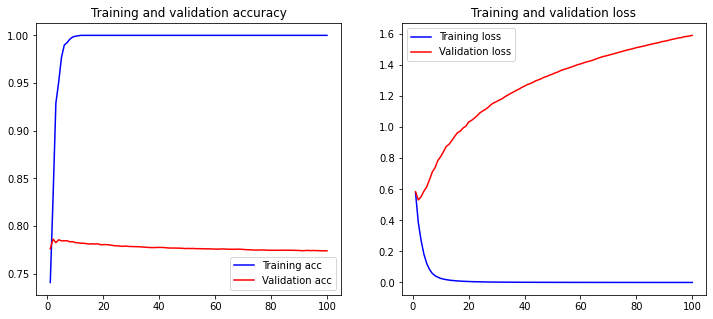

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [ ]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))


88/88 [==============================] - 4s 40ms/step - loss: 1.4331 - binary_accuracy: 0.7967
Training Accuracy: 0.7967
11/11 [==============================] - 1s 39ms/step - loss: 1.7387 - binary_accuracy: 0.7710
Testing Accuracy:  0.7710


In [ ]:
dev_sheet = pd.read_csv('/content/dev.csv', sep=',', usecols=range(22))
df = dev_sheet == 0;
binary_dev_sheet = dev_sheet[column_names_raw].where(df, 1);

temp_dev_data = np.zeros((dev_sheet.values.shape[0], 0));

for (c1, c2) in combinations: #for each combination we are calculating avg for them
  temp_dev = binary_dev_sheet[[c1,c2]];
  temp_dev_avg = np.round((temp_dev[c1] + temp_dev[c2])/2);
  temp_dev_data = np.column_stack((temp_dev_data, temp_dev_avg));

processed_dev_data = np.array(temp_dev_data);

temp = vectorizer.transform(dev_sheet.values[:, 1])
X_dev = np.array(temp.toarray());
Y_dev = np.array(processed_dev_data);

loss, accuracy = model.evaluate(X_dev, Y_dev, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

pred = model.predict(X_dev)

def show_example(idx):
    N_true = int(np.sum(Y_dev[idx]))
    print(dev_sheet['text'][idx])
    print("Prediction: {}".format("|".join(["{} ({:.3})".format(emotion_names[s], pred[idx][s])
                                            for s in pred[idx].argsort()[-N_true:][::-1]])))
    
show_example(215)

11/11 [==============================] - 1s 65ms/step - loss: 1.4702 - binary_accuracy: 0.7845
Testing Accuracy:  0.7845
Definitely the worst four-star hotel she's ever been in. The room and bathroom look like they were decorated 30 years ago. The carpet in the room is worn, the bed linen is stained (fortunately the pillowcases are clean and the bed is comfortable), the joints in the bathroom are dirty with old age, demanding renovation. There was no phone and a floor lamp in the room. The receptionist during the check-in did not honor us even with a shadow of a smile and all the time she was sipping candy (seriously . . . ) . Against the backdrop of all this, the gentleman who took care of the pool and the sauna, smiling and helpful, was a wonderful person.
Prediction: anger (0.982)|disgust (0.0162)|joy (0.000173)|anticipation (3.6e-05)|trust (3.4e-07)|sadness (1.77e-08)|fear (2.87e-09)|surprise (1.88e-09)
